In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/165-different-snakes-species/Csv/train.csv
/kaggle/input/165-different-snakes-species/Csv/test.csv
/kaggle/input/165-different-snakes-species/test/515/c53da8b756964482840873ffc04371b5.jpg
/kaggle/input/165-different-snakes-species/test/515/dc684bd688654baeb800fa9da20d6bb1.jpg
/kaggle/input/165-different-snakes-species/test/515/1d172b4e6a404079b4ad63847c0a8bbf.jpg
/kaggle/input/165-different-snakes-species/test/515/f12c79c89798485e90b9d86f9a362fa8.jpg
/kaggle/input/165-different-snakes-species/test/515/075acfccb92d4f1fb14ce5953c7461da.jpg
/kaggle/input/165-different-snakes-species/test/515/f96a810b6d88484db75f6a0bb4698285.jpg
/kaggle/input/165-different-snakes-species/test/515/80b7961b4cab417ab0eb19261ac54065.jpg
/kaggle/input/165-different-snakes-species/test/515/7f82805fff1d4355848bbce07c7c9bb6.jpg
/kaggle/input/165-different-snakes-species/test/515/97864864072b4242a60b457a7483a107.jpg
/kaggle/input/165-different-snakes-species/test/515/635e713339564ccfbf98820ffd4182d1.j

In [38]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from torch.utils.data import Dataset,DataLoader
from torchvision.utils import make_grid as vutils
from torchvision import transforms
from torch.optim import lr_scheduler
import random
import os
import cv2
import torch.optim as optim 
from tqdm import tqdm
import time
import copy
from PIL import Image
import joblib

In [46]:
seed=41
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda") if torch.backends.cuda.is_built() else torch.device("cpu")

lr=0.001
epochs=16
batch_size=24
gamma = 0.5
csv_combine = pd.read_csv(r"/kaggle/input/165-different-snakes-species/Csv/train.csv")
csv_test = pd.read_csv(r"/kaggle/input/165-different-snakes-species/Csv/test.csv") 
image_dim = 418

In [24]:
class_id = {}
for i,cl in enumerate(csv_combine.class_id.unique()):
    class_id[cl] = i
nclass = i+1 

csv_train = csv_combine
train_size = len(csv_train)
test_size = len(csv_test)

In [40]:
csv_train.head()

Unnamed: 0                binomial                   country  \
0           0  Agkistrodon contortrix  United States of America   
1           1  Agkistrodon contortrix  United States of America   
2           2  Agkistrodon contortrix  United States of America   
3           3  Agkistrodon contortrix  United States of America   
4           4  Agkistrodon contortrix  United States of America   

       continent        genus     family                              UUID  \
0  North America  Agkistrodon  Viperidae  20e23008100d4e249fd757c11fe059fe   
1  North America  Agkistrodon  Viperidae  0c6d14f33f404013ab116ab09880c523   
2  North America  Agkistrodon  Viperidae  3a31a32de0434653b4a82a30806f7a6d   
3  North America  Agkistrodon  Viperidae  1c5a3b2953c84d698fad8a40db91323e   
4  North America  Agkistrodon  Viperidae  e10c99a58c2546dab2c0d998de1f7c1b   

   class_id        snake_sub_family  poisonous         X         Y    height  \
0        18  Agkistrodon contortrix          1  0.507412  0.546939  0.916220   
1        18  Agkistrodon contortrix          1  0.503115  0.392086  0.835316   
2        18  Agkistrodon contortrix          1  0.353031  0.573312  0.652700   
3        18  Agkistrodon contortrix          1  0.436368  0.447794  0.918880   
4        18  Agkistrodon contortrix          1  0.512284  0.519067  0.923202   

      width  
0  0.951425  
1  0.965363  
2  0.709286  
3  0.834457  
4  0.631036

In [47]:
print("Species".ljust(97)+"No Of Images")
for i in csv_train.binomial.unique():
    print("{} {}".format(i.ljust(100),sum(csv_train.binomial == i)))

Species                                                                                          No Of Images
Agkistrodon contortrix                                                                               180
Agkistrodon piscivorus                                                                               200
Ahaetulla nasuta                                                                                     199
Ahaetulla prasina                                                                                    200
Arizona elegans                                                                                      181
Aspidites melanocephalus                                                                             154
Atractus crassicaudatus                                                                              187
Austrelaps superbus                                                                                  201
Bitis arietans                                    

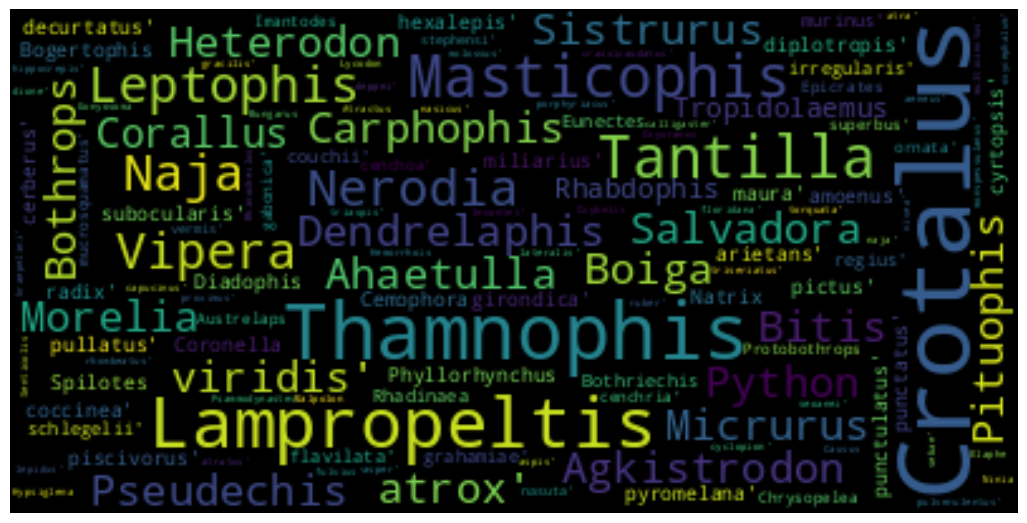

In [48]:
plt.rcParams['figure.figsize']=(13,13)
text = list(set((csv_test.binomial).unique()))
wordcloud = WordCloud(max_font_size=40,max_words=(csv_test.binomial).unique().shape[0]).generate(str(text))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# imagefolder = ImageFolder("../input/165-different-snakes-species/train", transform=transforms.ToTensor())
# image_dataloader=DataLoader(imagefolder, batch_size=64, shuffle=True, num_workers=0)

# def batch_mean_and_sd(loader):  
#     cnt = 0
#     fst_moment = torch.empty(3)
#     snd_moment = torch.empty(3)

#     for images, _ in tqdm(loader):
#         b, c, h, w = images.shape
#         nb_pixels = b * h * w
#         sum_ = torch.sum(images, dim=[0, 2, 3])
#         sum_of_square = torch.sum(images ** 2,
#                                   dim=[0, 2, 3])
#         fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
#         snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
#         cnt += nb_pixels

#     mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        
#     return mean,std

# mean, std = batch_mean_and_sd(image_dataloader)
#
# calculated mean and standard deviation
# mean = [0.4718, 0.4429, 0.3738] , Std = [0.2519, 0.2388, 0.2393]


In [49]:
from torchvision import transforms

transformation = {
    "transformation_image": transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(image_dim, image_dim), antialias=False),
        transforms.Normalize((0.4718, 0.4429, 0.3738), (0.2519, 0.2388, 0.2393))
    ])
}
    

transform_aug = transforms.Compose([
    transforms.RandomRotation(360)
])

In [50]:
class Dataset_receiver(Dataset):
    def __init__(self, csv, traindir, device, transform, class_id, aug = None):
        self.csv = csv
        self.traindir = traindir
        self.transform =transform
        self.device = device
        self.class_id = class_id
        self.aug = aug
    def __len__(self):
        return len(self.csv)
    def __getitem__(self, idx):
        
        csv = self.csv.iloc[[idx]]
        cl = csv["class_id"].values[0]
        location = self.traindir + "/" + str(cl) + "/" + csv["UUID"].values[0] + ".jpg"
        bbox = []
        image = Image.open(location)
        key = str(cl) + csv["UUID"].values[0]
        if self.aug != None:
            image = self.aug(image)
            
        image = np.array(image)

        
        # now [x center , y center , width , height]  
        shape = image.shape[0]
        try:
            x,y,width,height = [csv.X, csv.Y, csv.width, csv.height] * shape
            x0 ,y0 = int(x-(width/2)) ,int(y-(height/2))
            x1 ,y1 = int(x+(width/2)) ,int(y+(height/2))

            if x0 < 0:
                x0=0
            if x1 > shape:
                x1 = shape
            if y0 < 0:
                y0 = 0
            if y1 > shape:
                y1 = shape

            processed_image = self.transform["transformation_image"](image[y0:y1, x0:x1])
            return processed_image, torch.tensor(self.class_id[cl]) 
        except:
            processed_image = self.transform["transformation_image"](image)
            return processed_image, torch.tensor(self.class_id[cl])

In [51]:
train_dataset_aug = Dataset_receiver(csv_train, r"/kaggle/input/165-different-snakes-species/train", device, transformation, class_id, transform_aug)
train_dataset_normal = Dataset_receiver(csv_train, r"/kaggle/input/165-different-snakes-species/train", device, transformation, class_id)
test_dataset = Dataset_receiver(csv_test, r"/kaggle/input/165-different-snakes-species/test", device, transformation, class_id)

train_dataset = train_dataset_aug + train_dataset_normal
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

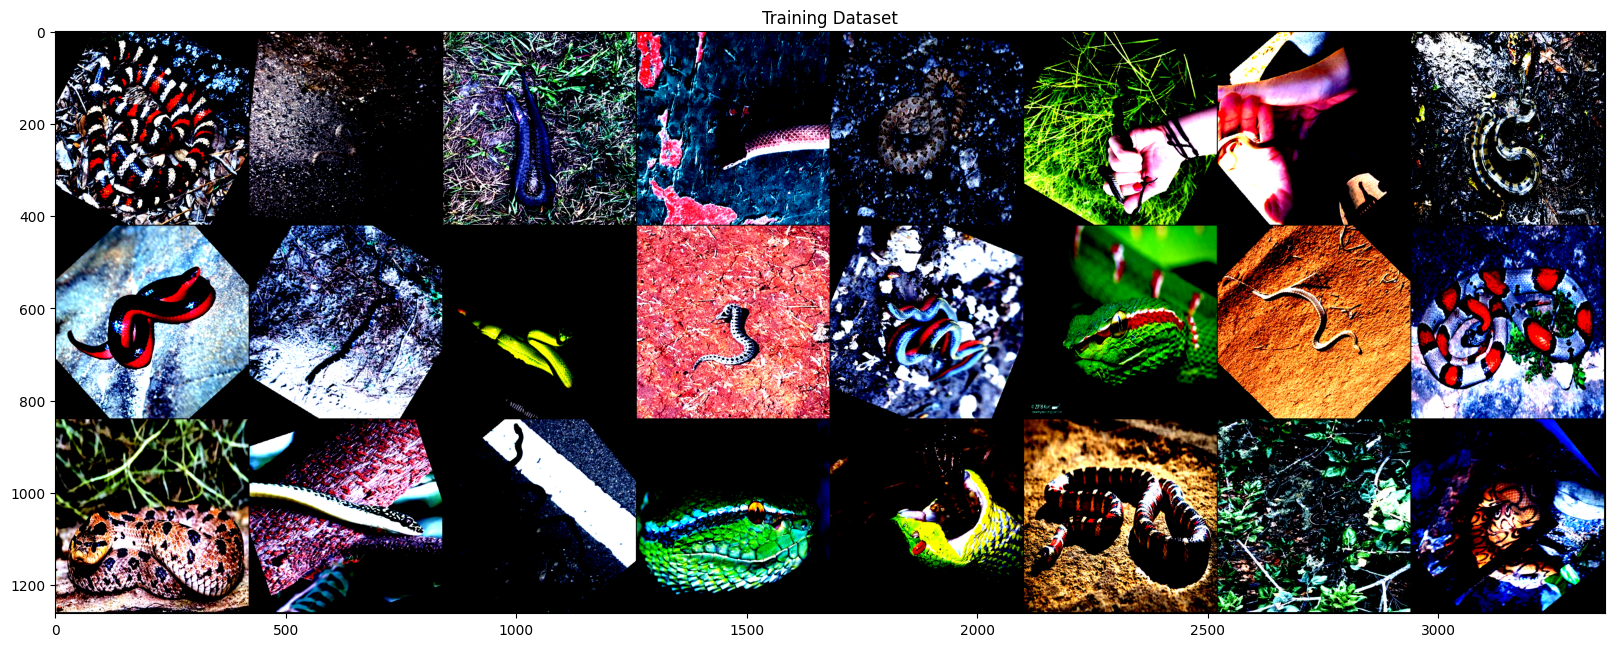

In [53]:
a,_ = next(iter(train_dataloader))
plt.figure(figsize=(20,20))
plt.title("Training Dataset")
plt.imshow(torch.swapdims(torch.swapdims(vutils(a,8,2),0,2),0,1))
plt.show()

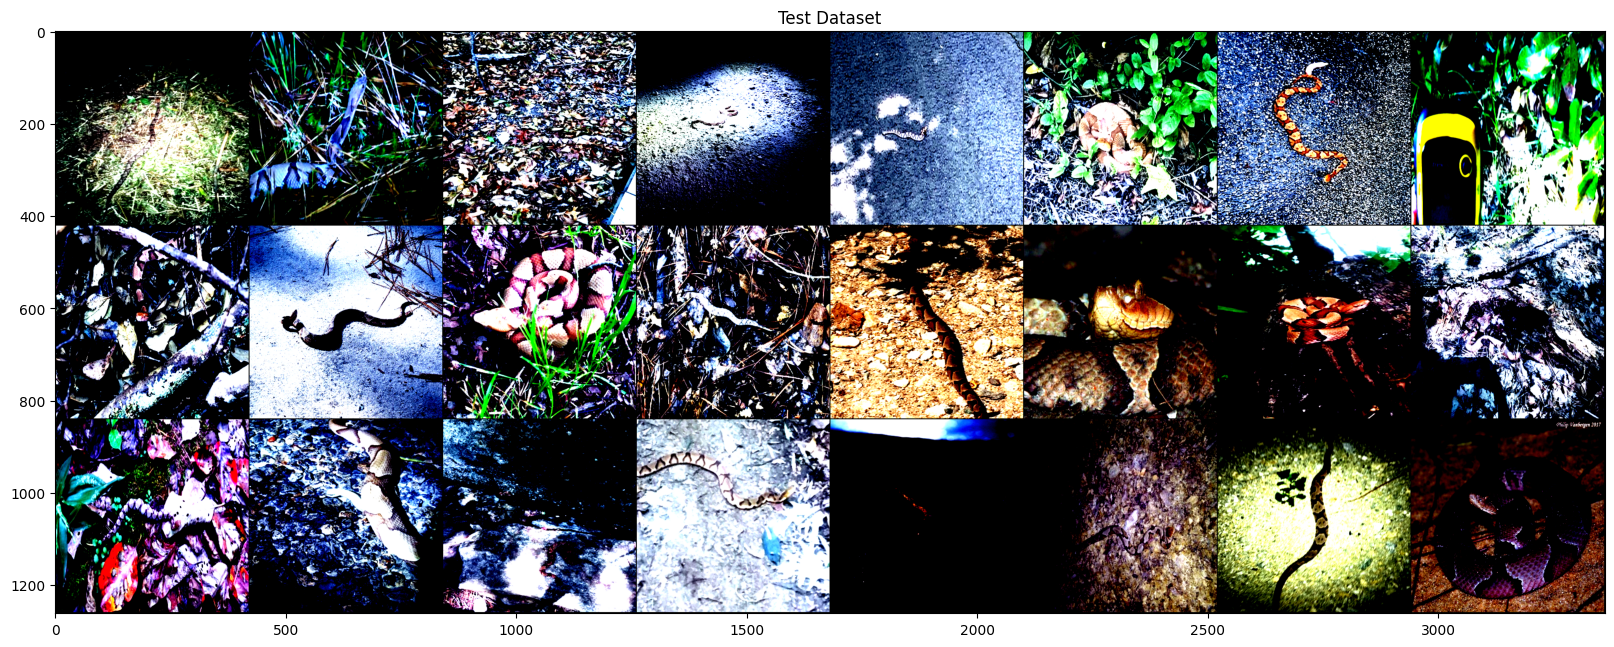

In [54]:
a,_ = next(iter(test_dataloader))
plt.figure(figsize=(20,20))
plt.title("Test Dataset")
plt.imshow(torch.swapdims(torch.swapdims(vutils(a,8,2),0,2),0,1))
plt.show()

In [56]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, verbose = 1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                dataloaders=train_dataloader
                model.train()  # Set model to training mode
                dataset_sizes=train_size*2

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            if verbose == 1:
                loop = tqdm(dataloaders)
            else:
                loop = dataloaders
            for inputs, labels in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()* inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if verbose == 1:
                    loop.set_postfix(loss=loss.item())
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def accuracy(dataloader, model):
    model.eval()
    result = []
    output = []
    label = []
    with torch.no_grad():
        for i, j in tqdm(dataloader):
            out = model(i.to(device))
            out = out.argmax(dim = 1).to(torch.device("cpu"))
            result += (j == out).tolist()
            output += out.tolist()
            label += j.tolist()
    print("Accuarcy Of the Test set: ",sum(result)/len(result))  
    return output, label
            

In [61]:
!pip install efficientnet_pytorch


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=2dc44f760b097062677a593a2f4a637ca8ee086c1172c9cd3f8d3a471bbcc9e4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [64]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Load EfficientNet-B3 (pretrained by default)
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=nclass)
model.fc = nn.Linear(model._fc.in_features, nclass)
model = model.to(device)

# The rest of your code remains unchanged
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=gamma)


Loaded pretrained weights for efficientnet-b3


In [65]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=epochs, verbose = 1)
output, label = accuracy(test_dataloader, model)
output, label = np.array(output), np.array(label)

Epoch 0/15
----------


100%|██████████| 1985/1985 [31:33<00:00,  1.05it/s, loss=1.55] 


train Loss: 2.4261 Acc: 0.3834
Epoch 1/15
----------


100%|██████████| 1985/1985 [28:31<00:00,  1.16it/s, loss=1.37] 


train Loss: 1.4621 Acc: 0.5919
Epoch 2/15
----------


100%|██████████| 1985/1985 [28:30<00:00,  1.16it/s, loss=0.803]


train Loss: 0.7983 Acc: 0.7660
Epoch 3/15
----------


100%|██████████| 1985/1985 [28:27<00:00,  1.16it/s, loss=0.471]


train Loss: 0.5862 Acc: 0.8249
Epoch 4/15
----------


100%|██████████| 1985/1985 [28:25<00:00,  1.16it/s, loss=0.155] 


train Loss: 0.3127 Acc: 0.9069
Epoch 5/15
----------


100%|██████████| 1985/1985 [28:24<00:00,  1.16it/s, loss=0.101] 


train Loss: 0.2350 Acc: 0.9286
Epoch 6/15
----------


100%|██████████| 1985/1985 [28:24<00:00,  1.16it/s, loss=0.824]  


train Loss: 0.1427 Acc: 0.9576
Epoch 7/15
----------


100%|██████████| 1985/1985 [28:22<00:00,  1.17it/s, loss=0.0397] 


train Loss: 0.1113 Acc: 0.9686
Epoch 8/15
----------


100%|██████████| 1985/1985 [28:24<00:00,  1.16it/s, loss=0.0216] 


train Loss: 0.0811 Acc: 0.9771
Epoch 9/15
----------


100%|██████████| 1985/1985 [28:26<00:00,  1.16it/s, loss=0.0256] 


train Loss: 0.0701 Acc: 0.9801
Epoch 10/15
----------


100%|██████████| 1985/1985 [28:18<00:00,  1.17it/s, loss=0.0972] 


train Loss: 0.0566 Acc: 0.9848
Epoch 11/15
----------


100%|██████████| 1985/1985 [28:28<00:00,  1.16it/s, loss=0.075]  


train Loss: 0.0500 Acc: 0.9868
Epoch 12/15
----------


100%|██████████| 1985/1985 [28:31<00:00,  1.16it/s, loss=0.0207] 


train Loss: 0.0434 Acc: 0.9890
Epoch 13/15
----------


100%|██████████| 1985/1985 [28:27<00:00,  1.16it/s, loss=0.0836]  


train Loss: 0.0409 Acc: 0.9898
Epoch 14/15
----------


100%|██████████| 1985/1985 [28:29<00:00,  1.16it/s, loss=0.0025]  


train Loss: 0.0388 Acc: 0.9898
Epoch 15/15
----------


100%|██████████| 1985/1985 [28:30<00:00,  1.16it/s, loss=0.111]  


train Loss: 0.0382 Acc: 0.9901
Training complete in 458m 17s


100%|██████████| 131/131 [01:14<00:00,  1.75it/s]

Accuarcy Of the Test set:  0.7495219885277247


In [69]:
id_name = list(class_id.values())

In [70]:
def Precision_recall(label, output, class_id):
    precision = []
    recall = []
    print("{}{}{}{}".format("Label".ljust(20), "Accuracy".ljust(20), "Precision".ljust(20), "Recall".ljust(20)))
    for i in list(class_id):
        label_truth = np.array(label) == i
        output_truth = np.array(output) == i
        temp_tp = label[label_truth] == output[label_truth]
        temp_fp = sum(output_truth) - sum(label_truth * output_truth)
        temp_fn = sum(label_truth) - sum(label_truth * output_truth)
        p = sum(temp_tp)/((sum(temp_tp)+temp_fp) if (sum(temp_tp)+temp_fp) != 0 else 1)
        r = sum(temp_tp)/((sum(temp_tp)+temp_fn) if (sum(temp_tp)+temp_fn) != 0 else 1)
        precision.append(p)
        recall.append(r)
        print("{}{}{}{}".format(str(i).ljust(20), str(sum(temp_tp)/len(temp_tp)).ljust(20), str(p).ljust(20), str(r).ljust(20)))    
    precision = sum(precision)/len(precision)
    recall = sum(recall)/len(recall)
    f1_score = 2*(precision*recall)/(precision+recall)
    print("F1 Score : {}".format(f1_score))
    return f1_score
torch.save(model,'model.h5')

In [71]:
Precision_recall(label, output, id_name)

Label               Accuracy            Precision           Recall              
0                   0.7777777777777778  0.7777777777777778  0.7777777777777778  
1                   0.6666666666666666  0.47619047619047616 0.6666666666666666  
2                   0.4482758620689655  0.6190476190476191  0.4482758620689655  
3                   0.64                0.5333333333333333  0.64                
4                   0.8181818181818182  0.782608695652174   0.8181818181818182  
5                   0.7619047619047619  0.7619047619047619  0.7619047619047619  
6                   0.8518518518518519  0.7931034482758621  0.8518518518518519  
7                   0.7272727272727273  0.6153846153846154  0.7272727272727273  
8                   0.92                0.92                0.92                
9                   0.8461538461538461  0.9166666666666666  0.8461538461538461  
10                  0.6923076923076923  0.47368421052631576 0.6923076923076923  
11                  0.807692

0.7464275804683113